In [1]:
# # #pip install spotipy
# # !pip install wordcloud
# !pip install moviepy
# !pip install scipy

In [2]:
# import libraries

import spotipy
import json
import pandas as pd
import pprint as pprint
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import linregress
import numpy as np
import io
from collections import Counter
from os import path
# from wordcloud import WordCloud

# import Spotify credentials

from config import client_id
from config import client_secret

from spotipy.oauth2 import SpotifyClientCredentials
client_credentials_manager = SpotifyClientCredentials(client_id,
                                                     client_secret)

sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

ModuleNotFoundError: No module named 'config'

In [ ]:
# Import CSV file with Billboard Top 100 Tracks data
# Use only top 10 / top 100 tracks per year to slim down sample size
# Create dataframe

billboard100_df = pd.read_csv("C:\\Users\\crnew\\Desktop\\Bootcamp-Spot-Homework\\Project 1\\billboard_top_10_annual.csv")
billboard100_df

In [ ]:
# For each top 10 song from 1950-2016 , call Spotify API, pull associated Artist and track info, append to URI list 

uri=[]

for i in range(len(billboard100_df["Song"])):
    try:
        uri.append(sp.search(q='artist:' + billboard100_df["Artist"][i] +
                             ' track:' + billboard100_df["Song"][i], type='track'))
    except: 
        continue
    i+=1
                 
uri

In [ ]:
# Using track info from URI list, call Spotify API to append URI into new_uri list
# Using URIs in new_uri list, call Spotify API to append audio features of each URI (track) into analysis list
# Assign empty, non-responses into empties list

analysis=[]

new_uri=[]
empties=[]   

for i in range(len(uri)):
    try:
        new_uri.append(uri[i]['tracks']["items"][0]["uri"])     
    except Exception as e:
        print(e)
        print(uri[i]['tracks']["items"])
        empties.append(uri[i]['tracks']["items"])

    try:
        analysis.append(sp.audio_features(uri[i]['tracks']["items"][0]["uri"]))
    except Exception as e:
        print(e)
        
analysis

In [ ]:
# For URIs (tracks) in analysis list, append tracks where they exist to track_list 

tracks_list =[]

for tracks in analysis:
    for track in tracks:
        if track:
            tracks_list.append(track)

In [ ]:
# Turn track_list into dataframe

tracks_list_df = pd.DataFrame(tracks_list)
tracks_list_df

In [ ]:
# Loop through just-created tracks_list_df column "URI", call Spotify API for each URI and append associated artist, 
# song name and song popularity to artists, songs and popularity lists

artists=[]
songs=[]
popularity=[]

for i in tracks_list_df["uri"]:
    artists.append(sp.track(i)["album"]["artists"][0]["name"])
    songs.append(sp.track(i)["name"])
    popularity.append(sp.track(i)["popularity"])

In [ ]:
# Assign values from artists, songs and popularity lists to following tracks_list_df columns:

tracks_list_df["Artist"]=artists
tracks_list_df["Songs"]=songs
tracks_list_df["Popularity"]=popularity

tracks_list_df.columns

# Transform tracks_list_df by renaming columns and assigning to final_df variable

final_df = tracks_list_df.rename(columns={'acousticness':"Acousticness", 'danceability':"Danceability", 
                                          'duration_ms':"Duration (ms)", 'energy':"Energy",'instrumentalness':"Instrumentalness",
                                          'key':"Key", 'liveness':"Liveness", 'loudness':"Loudness", 'mode':"Mode",
                                          'speechiness':"Speechiness",'tempo':"Tempo", 'time_signature':"Time-Sig",
                                          'uri':"URI", 'valence':"Valence", 'Artist':"Artist",'Songs':"Song",
                                          'Popularity':"Popularity"})

# Drop irrelevant columns from resulting dataframe

final_df = final_df.drop(["Key", "Mode","Time-Sig"], axis=1)

# Re-order columns of final_df

final_df = final_df[["Artist" , "Song", "Popularity", "Acousticness", "Danceability", 
             "Energy", "Instrumentalness", "Loudness", "Speechiness","Tempo", "Valence", "Duration (ms)", "URI"]]

# Set index of final_df on "URI"

final_df = final_df.set_index("URI")

final_df

In [ ]:
# Export final_df to CSV file
# Manually clean CSV file by attaching correct release date year from Billboard Top 10 CSV to each track,
# associated type of White House administration and whether country was at war or in peace-time

final_df.to_csv("final.csv", index=True, header=True)

In [ ]:
# Import resulting manual merge of Billboard Top 10 CSV and final_df CSV and turn into dataframe

merged_df = pd.read_csv("C:\\Users\\crnew\\Desktop\\Bootcamp-Spot-Homework\\Project 1\\final_csv.csv")

# Calculate the number of times the word 'love' or 'feat' appear in the merged_df column 'Song', assign to variables

love = merged_df['Song'].str.lower().str.contains('love', na=False)
feat = merged_df['Song'].str.lower().str.contains('feat', na=False)

# Create new columns in merged_df to contain latter variables

merged_df["Love"]=love
merged_df["Feat"]=feat

merged_df 

In [ ]:
# Create bins to group data by decade and label bins

bins = [1949,1959,1969,1979,1989,1999,2009,2019]
group_names=["1950s","1960s","1970s","1980s","1990s","2000s","2010s"]

# Group data by release date and group release dates by decade

merged_df["Decade"] = pd.cut(merged_df["Release Date"], bins, labels=group_names)

merged_df

In [ ]:
# Create new dataframe to group data by decade

group_by_decade_df = merged_df.groupby("Decade")

# Calculate the mean values for each grouped-by decade for each of the following

group_by_decade_df["Popularity","Acousticness","Danceability","Energy","Instrumentalness",
                   "Loudness","Speechiness","Duration (ms)","Love","Feat"].mean()


# Take mean value calculations and use aggregate function to sum values in "Love" and "Feat" columns

group_by_decade_df = group_by_decade_df.agg({"Popularity":"mean","Acousticness":"mean",
                                          "Danceability":"mean","Energy":"mean","Instrumentalness":"mean",
                   "Loudness":"mean","Speechiness":"mean","Duration (ms)":"mean","Love":"sum","Feat":"sum"})

group_by_decade_df

In [ ]:
# Graph values in group_by_decade_df; index their change in value to 100 using 1950s values as the starting point = 100 

x_axis = np.arange(1950,2020,10)

fig, ax = plt.subplots(figsize=(11,9))

ax.errorbar(x_axis, group_by_decade_df["Popularity"]/34.312500*100, color="purple", marker="o", markersize=5, label="Popularity", dashes=[2, 2, 2, 2], alpha =.75, linewidth=2)
ax.errorbar(x_axis, group_by_decade_df["Acousticness"]/.775090*100, color="green", marker="o", markersize=5, label="Acousticness", dashes=[2, 2, 2, 2], alpha =.75, linewidth=2)
ax.errorbar(x_axis, group_by_decade_df["Danceability"]/.480525*100, color="red", marker="o", markersize=5, label="Danceability", dashes=[2, 2, 2, 2], alpha =.75, linewidth=2)
ax.errorbar(x_axis, group_by_decade_df["Energy"]/.341433*100, color="blue", marker="o", markersize=5, label="Energy", dashes=[2, 2, 2, 2], alpha =.75, linewidth=2)
ax.errorbar(x_axis, group_by_decade_df["Instrumentalness"]/.100617*100, color="brown", marker="o", markersize=5, label="Instrumentalness", dashes=[2, 2, 2, 2], alpha =.75, linewidth=2)
ax.errorbar(x_axis, (1+(1-(group_by_decade_df["Loudness"]/(-12.108950)))*100)+100, color="gray", marker="o", markersize=5, label="Loudness", dashes=[2, 2, 2, 2], alpha =.75, linewidth=2)
ax.errorbar(x_axis, group_by_decade_df["Speechiness"]/.046331*100, color="magenta", marker="o", markersize=5, label="Speechiness", dashes=[2, 2, 2, 2], alpha =.75, linewidth=2)
ax.errorbar(x_axis, group_by_decade_df["Duration (ms)"]/168631.575000*100, color="orange", marker="o", markersize=5, label="Duration (ms)", dashes=[2, 2, 2, 2], alpha =.75, linewidth=2)


plt.title("Mean Song Characteristics by Decade")
plt.xlabel("Decade")
plt.ylabel("Mean Characteristic (Indexed to 100 as of 1950)")
plt.grid(linestyle="none")
plt.axhline(y=100,color="black", alpha=1)
plt.legend()
plt.show()
fig.savefig("Mean Song Characteristic by Decade.png")

In [ ]:
# Graph % of songs with 'Love' in title since 1950s

x_axis = np.arange(1950,2020, 10)

fig, ax = plt.subplots(figsize=(7,5))

        
ax.errorbar(x_axis, group_by_decade_df["Love"]/pd.value_counts(merged_df['Decade'].values, sort=False)*100,
        fmt="-o", color="r",alpha=0.75, label="Love")

plt.title("% of Songs with 'Love' in Title by Decade")
plt.ylabel("%")
plt.grid(linestyle="dashed")
plt.xlabel("Decade")
fig.savefig("Love.png")

In [ ]:
# Graph % of songs with 'feat' in title since 1950s

x_axis = np.arange(1950,2020, 10)

fig, ax = plt.subplots(figsize=(7,5))

        
ax.errorbar(x_axis, group_by_decade_df["Feat"]/pd.value_counts(merged_df['Decade'].values, sort=False)*100,
        fmt="-o", color="r",alpha=0.75, label="Feat")

plt.title("% of Songs Featuring a Cameo by Decade")
plt.ylabel("%")
plt.grid(linestyle="dashed")
plt.xlabel("Decade")
fig.savefig("Feat.png")

In [ ]:
# Graph individual audio features values since 1950s

x_axis = np.arange(1950,2020, 10)

fig, ax = plt.subplots(figsize=(7,5))

ax.errorbar(x_axis, group_by_decade_df["Popularity"], fmt="-o", color="purple",alpha=0.75, label="Popularity")

plt.title("Current Popularity by Release Date Decade")
plt.xlabel("Decade")
plt.ylabel("Popularity")
plt.grid(linestyle="dashed")
plt.legend()
plt.show()
fig.savefig("Popularity.png")

In [ ]:
# Graph individual audio features values since 1950s

x_axis = np.arange(1950,2020, 10)

fig, ax = plt.subplots(figsize=(7,5))

ax.errorbar(x_axis, group_by_decade_df["Acousticness"], fmt="-o", color="green",alpha=0.75, label="Acousticness")

plt.title("Mean Acoustincess by Release Date Decade")
plt.xlabel("Decade")
plt.ylabel("Acousticness")
plt.grid(linestyle="dashed")
plt.legend()
plt.show()
fig.savefig("Acousticness.png")

In [ ]:
# Graph individual audio features values since 1950s

x_axis = np.arange(1950,2020, 10)

fig, ax = plt.subplots(figsize=(7,5))

ax.errorbar(x_axis, group_by_decade_df["Danceability"], fmt="-o", color="r",alpha=0.75, label="Danceability")

plt.title("Mean Danceability by Release Date Decade")
plt.xlabel("Decade")
plt.ylabel("Danceability")
plt.grid(linestyle="dashed")
plt.legend()
plt.show()
fig.savefig("Danceability.png")

In [ ]:
# Graph individual audio features values since 1950s

x_axis = np.arange(1950,2020, 10)

fig, ax = plt.subplots(figsize=(7,5))

ax.errorbar(x_axis, group_by_decade_df["Energy"], fmt="-o", color="b",alpha=0.75, label="Energy")

plt.title("Mean Energy by Release Date Decade")
plt.xlabel("Decade")
plt.ylabel("Energy")
plt.grid(linestyle="dashed")
plt.legend()
plt.show()
fig.savefig("Energy.png")

In [ ]:
# Graph individual audio features values since 1950s

x_axis = np.arange(1950,2020, 10)

fig, ax = plt.subplots(figsize=(7,5))

ax.errorbar(x_axis, group_by_decade_df["Instrumentalness"], fmt="-o", color="brown",alpha=0.75, label="Instrumentalness")

plt.title("Mean Instrumentalness by Release Date Decade")
plt.xlabel("Decade")
plt.ylabel("Instrumentalness")
plt.grid(linestyle="dashed")
plt.legend()
plt.show()
fig.savefig("Instrumentalness.png")

In [ ]:
# Graph individual audio features values since 1950s

x_axis = np.arange(1950,2020, 10)

fig, ax = plt.subplots(figsize=(7,5))

ax.errorbar(x_axis, group_by_decade_df["Loudness"], fmt="-o", color="gray",alpha=0.75, label="Loudness")

plt.title("Mean Loudness by Release Date Decade")
plt.xlabel("Decade")
plt.ylabel("Loudness")
plt.grid(linestyle="dashed")
plt.legend()
plt.show()
fig.savefig("Loudness.png")

In [ ]:
# Graph individual audio features values since 1950s

x_axis = np.arange(1950,2020, 10)

fig, ax = plt.subplots(figsize=(7,5))

ax.errorbar(x_axis, group_by_decade_df["Speechiness"], fmt="-o", color="magenta",alpha=0.75, label="Speechiness")

plt.title("Mean Speechiness by Release Date Decade")
plt.xlabel("Decade")
plt.ylabel("Speechiness")
plt.grid(linestyle="dashed")
plt.legend()
plt.show()
fig.savefig("Speechiness.png")

In [ ]:
# Graph individual audio features values since 1950s

x_axis = np.arange(1950,2020, 10)

fig, ax = plt.subplots(figsize=(7,5))

ax.errorbar(x_axis, group_by_decade_df["Duration (ms)"], fmt="-o", color="orange",alpha=0.75, label="Duration (ms)")

plt.title("Mean Duration by Release Date Decade")
plt.xlabel("Decade")
plt.ylabel("Duration (ms)")
plt.grid(linestyle="dashed")
plt.legend()
plt.show()
fig.savefig("Duration.png")

In [ ]:
# Create new dataframe to merge by White House administration (R vs. D)

group_by_wh_df = merged_df.groupby("WH")

group_by_wh_df = group_by_wh_df.agg({"Popularity":"mean","Acousticness":"mean",
                                          "Danceability":"mean","Energy":"mean","Instrumentalness":"mean",
                   "Loudness":"mean","Speechiness":"mean","Duration (ms)":"mean","Love":"sum"})
group_by_wh_df

In [ ]:
# Create new dataframe to merge by White House administration (Peace vs. War)

group_by_war_df = merged_df.groupby("War?")

group_by_war_df = group_by_war_df.agg({"Popularity":"mean","Acousticness":"mean",
                                          "Danceability":"mean","Energy":"mean","Instrumentalness":"mean",
                   "Loudness":"mean","Speechiness":"mean","Duration (ms)":"mean","Love":"sum"})

group_by_war_df

In [ ]:
stats_ttest =[]

column_names = ["Popularity","Acousticness","Danceability","Energy","Instrumentalness",
                   "Loudness","Speechiness","Tempo","Valence"]

number = {key:{} for key in column_names}

stats_ttesty_v_1950 =[]

column_names = ["Popularity","Acousticness","Danceability","Energy","Instrumentalness",
                   "Loudness","Speechiness","Tempo","Valence"]

number = {key:{} for key in column_names}

for column_name in column_names:
    for i in range(len(group_by_war_df)):
        try:
            ttest_result = stats.ttest_1samp(group_by_war_df[0][column_name], group_by_war_df[i][column_name].mean())
            stats_ttesty_v_1950.append(ttest_result)
            number[column_name][i]=ttest_result
            print(ttest_result)
        except IndexError as error:
            print("You have reached the end of the decade vs. 1950. No more comparisons can be made.")

In [ ]:
# Calculate the % of songs containing the word 'love' during peace or war, graph

war = group_by_war_df["Love"][1]/war_count*100
peace = group_by_war_df["Love"][0]/peace_count*100

print("In war-time "+(str(round(war))+ "% of songs include 'Love' in the title vs." +(str(round(peace))+"% in peace-time")))

x_axis = np.arange(len(group_by_war_df["Popularity"]))
y_axis = [peace,war]

fig, ax = plt.subplots(figsize=(7,5))

ax.bar(x_axis,y_axis,color="red",align="center",alpha=0.5)

tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, ["Peace","War"])

plt.title("% of Songs Containing the Word 'Love'")
plt.ylabel("%")

for x,y in zip(x_axis,y_axis):

    label = "{:.2f}%".format(y)

    plt.annotate(label, (x,y),textcoords="offset points", # how to position the text
                 xytext=(0,-20),ha='center',weight="bold")


plt.show()
fig.savefig("Love_war_peace.png")

In [ ]:
# Create WordCloud graph to underscore the pervasiveness of certain words in song titles

d = path.dirname("songs.txt")

text = io.open(path.join(d, 'songs.txt')).read()

words = text.split()
print(Counter(words))

# Generate a word cloud image

font_path = path.join(d, 'Symbola.ttf')
word_cloud = WordCloud(font_path=font_path, background_color="black",colormap="Reds",
                       stopwords=["Version","Single","Remaster","Single Version", 
                                  "Remastered","The","In","of","To","From","with","and","is","it", "Various"]).generate(text)

# Display the generated image:
plt.imshow(word_cloud)
plt.axis("off")
plt.show()
word_cloud.to_file("Song Word Cloud.png")

In [ ]:
# Create WordCloud graph to underscore the pervasiveness of certain artists in Billboard Top 10

d = path.dirname("artists.txt")

text = io.open(path.join(d, 'artists.txt')).read()

words = text.split()
print(Counter(words))

# Generate a word cloud image
font_path = path.join(d, 'Symbola.ttf')

word_cloud = WordCloud(font_path=font_path, background_color="black",colormap="Reds",
                       stopwords=["The","Various", "Artists"]).generate(text)

# Display the generated image:
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

In [ ]:
# # Perform the ANOVA
stats.f_oneway(Group_1950s_dan, Group_1960s_dan, Group_1970s_dan, Group_1980s_dan, Group_1990s_dan, Group_2000s_dan, Group_2010s_dan)

# # Create a boxplot to compare means of energy
merged_df.boxplot("Energy", by="Decade", figsize=(20, 10))

# # Extract individual groups
Group_1950s_ener = pd.to_numeric(merged_df[merged_df["Decade"] == "1950s"]["Energy"])
Group_1960s_ener = pd.to_numeric(merged_df[merged_df["Decade"] == "1960s"]["Energy"])
Group_1970s_ener = pd.to_numeric(merged_df[merged_df["Decade"] == "1970s"]["Energy"])
Group_1980s_ener = pd.to_numeric(merged_df[merged_df["Decade"] == "1980s"]["Energy"])
Group_1990s_ener = pd.to_numeric(merged_df[merged_df["Decade"] == "1990s"]["Energy"])
Group_2000s_ener= pd.to_numeric(merged_df[merged_df["Decade"] == "2000s"]["Energy"])
Group_2010s_ener= pd.to_numeric(merged_df[merged_df["Decade"] == "2010s"]["Energy"])

# # Perform the ANOVA
stats.f_oneway(Group_1950s_ener, Group_1960s_ener, Group_1970s_ener, Group_1980s_ener, Group_1990s_ener, Group_2000s_ener, Group_2010s_ener)

number["Tempo"][2]

# # merged_df[merged_df["Decade"] == "1950s"]["Energy"]

# # Create a boxplot to compare means of instrumentalness
merged_df.boxplot("Instrumentalness", by="Decade", figsize=(20, 10))

# # Extract individual groups
Group_1950s_inst = pd.to_numeric(merged_df[merged_df["Decade"] == "1950s"]["Instrumentalness"])
Group_1960s_inst = pd.to_numeric(merged_df[merged_df["Decade"] == "1960s"]["Instrumentalness"])
Group_1970s_inst = pd.to_numeric(merged_df[merged_df["Decade"] == "1970s"]["Instrumentalness"])
Group_1980s_inst = pd.to_numeric(merged_df[merged_df["Decade"] == "1980s"]["Instrumentalness"])
Group_1990s_inst = pd.to_numeric(merged_df[merged_df["Decade"] == "1990s"]["Instrumentalness"])
Group_2000s_inst= pd.to_numeric(merged_df[merged_df["Decade"] == "2000s"]["Instrumentalness"])
Group_2010s_inst= pd.to_numeric(merged_df[merged_df["Decade"] == "2010s"]["Instrumentalness"])

# # Perform the ANOVA
stats.f_oneway(Group_1950s_inst, Group_1960s_inst, Group_1970s_inst, Group_1980s_inst, Group_1990s_inst, Group_2000s_inst, Group_2010s_inst)

# # Create a boxplot to compare means of loudness
merged_df.boxplot("Loudness", by="Decade", figsize=(20, 10))

# # Extract individual groups
Group_1950s_loud = pd.to_numeric(merged_df[merged_df["Decade"] == "1950s"]["Loudness"])
Group_1960s_loud = pd.to_numeric(merged_df[merged_df["Decade"] == "1960s"]["Loudness"])
Group_1970s_loud = pd.to_numeric(merged_df[merged_df["Decade"] == "1970s"]["Loudness"])
Group_1980s_loud = pd.to_numeric(merged_df[merged_df["Decade"] == "1980s"]["Loudness"])
Group_1990s_loud = pd.to_numeric(merged_df[merged_df["Decade"] == "1990s"]["Loudness"])
Group_2000s_loud= pd.to_numeric(merged_df[merged_df["Decade"] == "2000s"]["Loudness"])
Group_2010s_loud= pd.to_numeric(merged_df[merged_df["Decade"] == "2010s"]["Loudness"])

# # Perform the ANOVA
stats.f_oneway(Group_1950s_loud, Group_1960s_loud, Group_1970s_loud, Group_1980s_loud, Group_1990s_loud, Group_2000s_loud, Group_2010s_loud)

# # Create a boxplot to compare means of speechniess
merged_df.boxplot("Speechiness", by="Decade", figsize=(20, 10))

# # Extract individual groups
Group_1950s_speech = pd.to_numeric(merged_df[merged_df["Decade"] == "1950s"]["Speechiness"])
Group_1960s_speech = pd.to_numeric(merged_df[merged_df["Decade"] == "1960s"]["Speechiness"])
Group_1970s_speech = pd.to_numeric(merged_df[merged_df["Decade"] == "1970s"]["Speechiness"])
Group_1980s_speech = pd.to_numeric(merged_df[merged_df["Decade"] == "1980s"]["Speechiness"])
Group_1990s_speech = pd.to_numeric(merged_df[merged_df["Decade"] == "1990s"]["Speechiness"])
Group_2000s_speech= pd.to_numeric(merged_df[merged_df["Decade"] == "2000s"]["Speechiness"])
Group_2010s_speech= pd.to_numeric(merged_df[merged_df["Decade"] == "2010s"]["Speechiness"])

# # Perform the ANOVA
stats.f_oneway(Group_1950s_speech, Group_1960s_speech, Group_1970s_speech, Group_1980s_speech, Group_1990s_speech, Group_2000s_speech, Group_2010s_speech)

# # Create a boxplot to compare means of tempo
merged_df.boxplot("Tempo", by="Decade", figsize=(20, 10))

# # Extract individual groups
Group_1950s_tempo = pd.to_numeric(merged_df[merged_df["Decade"] == "1950s"]["Tempo"])
Group_1960s_tempo = pd.to_numeric(merged_df[merged_df["Decade"] == "1960s"]["Tempo"])
Group_1970s_tempo = pd.to_numeric(merged_df[merged_df["Decade"] == "1970s"]["Tempo"])
Group_1980s_tempo = pd.to_numeric(merged_df[merged_df["Decade"] == "1980s"]["Tempo"])
Group_1990s_tempo = pd.to_numeric(merged_df[merged_df["Decade"] == "1990s"]["Tempo"])
Group_2000s_tempo= pd.to_numeric(merged_df[merged_df["Decade"] == "2000s"]["Tempo"])
Group_2010s_tempo= pd.to_numeric(merged_df[merged_df["Decade"] == "2010s"]["Tempo"])

# # Perform the ANOVA
stats.f_oneway(Group_1950s_tempo, Group_1960s_tempo, Group_1970s_tempo, Group_1980s_tempo, Group_1990s_tempo, Group_2000s_tempo, Group_2010s_tempo)

# # Create a boxplot to compare means of valence
merged_df.boxplot("Valence", by="Decade", figsize=(20, 10))

# # Extract individual groups
Group_1950s_val = pd.to_numeric(merged_df[merged_df["Decade"] == "1950s"]["Valence"])
Group_1960s_val = pd.to_numeric(merged_df[merged_df["Decade"] == "1960s"]["Valence"])
Group_1970s_val = pd.to_numeric(merged_df[merged_df["Decade"] == "1970s"]["Valence"])
Group_1980s_val = pd.to_numeric(merged_df[merged_df["Decade"] == "1980s"]["Valence"])
Group_1990s_val = pd.to_numeric(merged_df[merged_df["Decade"] == "1990s"]["Valence"])
Group_2000s_val= pd.to_numeric(merged_df[merged_df["Decade"] == "2000s"]["Valence"])
Group_2010s_val= pd.to_numeric(merged_df[merged_df["Decade"] == "2010s"]["Valence"])

# # Perform the ANOVA
stats.f_oneway(Group_1950s_val, Group_1960s_val, Group_1970s_val, Group_1980s_val, Group_1990s_val, Group_2000s_val, Group_2010s_val)

years =["1950s", "1960s", "1970s", "1980s", "1990s", "2000s", "2010s"]
year_dfs=[merged_df[merged_df["Decade"]==year] for year in years]
year_dfs[0].head()

stats_ttest =[]

column_names = ["Popularity","Acousticness","Danceability","Energy","Instrumentalness",
                   "Loudness","Speechiness","Tempo","Valence"]

number = {key:{} for key in column_names}

stats_ttest_v_1950 =[]

column_names = ["Popularity","Acousticness","Danceability","Energy","Instrumentalness",
                   "Loudness","Speechiness","Tempo","Valence"]

number = {key:{} for key in column_names}

for column_name in column_names:
    for i in range(len(year_dfs)):
        try:
            ttest_result = stats.ttest_1samp(year_dfs[0][column_name], year_dfs[i][column_name].mean())
            stats_ttest_v_1950.append(ttest_result)
            number[column_name][i]=ttest_result
            print(ttest_result)
        except IndexError as error:
            print("You have reached the end of the decade vs. 1950. No more comparisons can be made.")

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from math import pi


df = group_by_decade_df.mean().reset_index()

# Run this part only once....

df["Acousticness"]=df["Acousticness"]/.77509
df["Danceability"]=df["Danceability"]/.480525
df["Energy"]=df["Energy"]/.341433
df["Instrumentalness"]=df["Instrumentalness"]/.100617
df["Loudness"]=abs(1-((df["Loudness"])/-12.10895))+1
df["Speechiness"]=df["Speechiness"]/.046331

the_50s = df.drop(["Decade","Release Date","Popularity"],axis=1).iloc[0].values
the_60s = df.drop(["Decade","Release Date","Popularity"],axis=1).iloc[1].values
the_70s = df.drop(["Decade","Release Date","Popularity"],axis=1).iloc[2].values
the_80s = df.drop(["Decade","Release Date","Popularity"],axis=1).iloc[3].values
the_90s = df.drop(["Decade","Release Date","Popularity"],axis=1).iloc[4].values
the_2000s = df.drop(["Decade","Release Date","Popularity"],axis=1).iloc[5].values
the_2010s = df.drop(["Decade","Release Date","Popularity"],axis=1).iloc[6].values

# number of variable
categories= ["Acousticness","Danceability","Energy","Instrumentalness","Loudness",
                   "Speechiness","Tempo","Valence"]
N = len(categories)
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories)
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([.5,1.0,1.5,2.0], [".5","1.0","1.5","2.0"], color="grey", size=12)
plt.ylim(0,2.1)
 
 
# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
 
# The 50s
values=the_50s.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="1950s")
ax.fill(angles, values, 'b', alpha=0.1)

# The 60s
values=the_60s.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="1960s")
ax.fill(angles, values, 'r', alpha=0.1)

# The 70s
values=the_70s.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="1970s")
ax.fill(angles, values, 'g', alpha=0.1)
 
# The 80s
values=the_80s.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="1980s")
ax.fill(angles, values, 'y', alpha=0.1)    

# The 90s
values=the_90s.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="1990s")
ax.fill(angles, values, 'p', alpha=0.1)    
    
# The 2000s
values=the_2000s.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="2000s")
ax.fill(angles, values, 'k', alpha=0.1)     
    
# # The 2010s
values=the_2010s.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="2010s")
ax.fill(angles, values, 'o', alpha=0.1)      
    
# Add legend
plt.legend(loc='best', bbox_to_anchor=(0.1, 0.1))







In [ ]:
# Statistics:
# Democrat	Republican	
# 	n=194	n=355	p value
# Popularity	51.89175258	58.16901408	0.0001
# 	19.31985928	17.07509661	
			
# Acousticness	0.438402706	0.323949028	0.0001
# 	0.340840066	0.307488585	
			
# Danceability	0.582329897	0.628414085	0.011
# 	0.173650189	0.153620912	
			
# Energy	0.509042268	0.594396901	0.0001
# 	0.215158116	0.218678543	
			
# Instrument	0.052567218	0.323949028	0.0001
# 	0.183650929	0.136346087	
			
# Loudness	-9.812505155	-8.697546479	0.0006
# 	3.374658847	3.795378284	
			
# Speechniess	0.04505	0.064576056	0.0002
# 	0.029075887	0.068738964	
			
# Tempo	114.1461546	116.0601831	0.4398
# 	29.07148754	26.88234182	
			
# Valence	0.578537629	0.604039155	0.2672
# 	0.266251837	0.252423795	


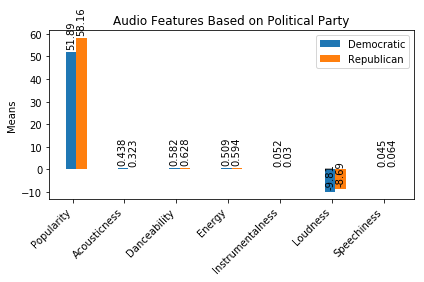

In [10]:
# bar plot:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = ["Popularity","Acousticness","Danceability","Energy","Instrumentalness", "Loudness","Speechiness"]
Democratic_means = [51.89, 0.438, 0.582, 0.509, 0.052, -9.81, 0.045]
Republican_means = [58.16, 0.323, 0.628, 0.594, 0.030, -8.69, 0.064]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, Democratic_means, width, label='Democratic')
rects2 = ax.bar(x + width/2, Republican_means, width, label='Republican')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Means')
ax.set_title('Audio Features Based on Political Party')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
# xticks_pos = [0.65*patch.get_width() + patch.get_xy()[0] for patch in rects1]

plt.xticks(xticks_pos, labels,  ha='right', rotation=45)


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', rotation = 90)
        

# ax.autoscale(tight=True)
autolabel(rects1)
autolabel(rects2)

fig.tight_layout()


plt.show()

In [ ]:
# war v peace stats:
    
# war	peace	
# 	195	n=355	
# Popularity	51.85051546	63.75625	0.0001
# 	17.17491015	14.07381568	
			
# Acousticness	0.447788789	0.211846088	0.0001
# 	0.336654836	0.132665738	
			
# Danceability	0.595912371	0.66055625	0.0001
# 	0.161647661	0.132665738	
			
# Energy	0.517438144	0.64623125	0.0001
# 	0.22246534	0.178391987	
			
# Instrument	0.043515755	0.024046109	0.0513
# 	0.156259266	0.117646121	
			
# Loudness	-9.80143299	-8.31095	0.0001
# 	3.456229339	3.280009046	
			
# Speechniess	0.048945361	0.061395	0.0122
# 	0.036420239	0.064013157	
